# 8. Transformers for Kubernetes Operations: Enhancing Prediction Accuracy with NLP

## Introduction

Welcome to the 8th notebook in our series on **AI for Kubernetes operations**! In this notebook, we take a leap into cutting-edge AI techniques by leveraging **transformer models** like **BERT** for Kubernetes event classification. 

Transformers are a revolutionary class of models that have redefined how machines process sequential data, particularly in natural language processing (NLP). Their ability to capture **contextual relationships** in text makes them highly effective for understanding Kubernetes operational data, such as logs and events.

### Objectives

By the end of this notebook, you will be able to:
1. Understand the foundational concepts behind transformer models and their advantages over traditional approaches.
2. Fine-tune a pretrained transformer model (**BERT**) for Kubernetes event classification.
3. Evaluate the model's performance using metrics such as accuracy, precision, recall, and confusion matrices.

### What Are Transformers, and Why Do They Matter?

Transformers are advanced neural network architectures designed to process and analyze sequential data. Unlike traditional sequence models like LSTMs or RNNs, transformers use a mechanism called **self-attention** to understand relationships between different parts of the input sequence.

<img src="https://machinelearningmastery.com/wp-content/uploads/2021/08/attention_research_1.png" alt="The encoder-decoder structure of the Transformer architecture" width="600"/>
<p><em>Source: Attention Is All You Need, 2017.</em></p>

#### Key Features of Transformers:
1. **Self-Attention**: Captures dependencies between words, regardless of their position in the sequence.
   - Example: In the phrase "The pod crashed because it ran out of memory," transformers link "crashed" with "ran out of memory" even though the words are separated.
2. **Parallel Processing**: Unlike RNNs, transformers process input sequences in parallel, making them faster and more scalable.
3. **Pretrained Models**: Models like **BERT** come pretrained on massive datasets, enabling them to quickly adapt to specific tasks with minimal additional training.

#### Why Do Transformers Exist?
Transformers were introduced to overcome the limitations of earlier sequence models, which struggled with:
- Capturing long-range dependencies in text.
- Training inefficiencies due to sequential data processing.

By addressing these issues, transformers enable:
- **Faster Training**: Thanks to parallelization.
- **Better Context Understanding**: Through self-attention.

### Relevance to Kubernetes Operations

Kubernetes environments generate vast amounts of sequential data, such as:
- **Logs**: Event logs describing system behaviors (e.g., "Pod restarted due to memory exhaustion").
- **Metrics**: Time-series data on resource utilization (e.g., CPU usage, memory allocation).

Transformers, particularly models like **BERT**, excel in understanding the context within such text-based data. For example:
- **Use Case**: Classifying Kubernetes events (e.g., Normal, Warning, Error) based on operational logs.
- **Benefit**: Accurately identifying and categorizing events helps operators prioritize and respond to critical issues faster.

## 1. Installing the Required Libraries

Before we start, we need to install the necessary libraries. These include **transformers**, **torch**, and **scikit-learn**, which are required to build and fine-tune the BERT model. Run the following cell to install these libraries:

In [52]:
%pip install transformers torch scikit-learn matplotlib seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


### System Information

In this section, we check the environment in which we are running the code. This includes the Python version, PyTorch version, and whether a compatible GPU or Apple MPS is available.
This helps us ensure that we are leveraging the best computational resources for model training and evaluation.

In [32]:
# What version of Python do you have?
import sys
import platform
import pandas as pd
import sklearn as sk
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AdamW,
)

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("NVIDIA/CUDA GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

torch.cuda.empty_cache()

Python Platform: macOS-15.2-arm64-arm-64bit
PyTorch Version: 2.5.1

Python 3.12.4 (main, Jun  6 2024, 18:26:44) [Clang 15.0.0 (clang-1500.3.9.4)]
Pandas 2.2.3
Scikit-Learn 1.6.1
NVIDIA/CUDA GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


## **2. Loading and Preparing the Dataset**

In this section, we load a preprocessed Kubernetes dataset containing event information and operational metrics. We then aggregate event-related columns into a single target column, `event_message`, which simplifies our classification task. This column is encoded into numerical values, making it ready for use with our BERT model.

### **Why Aggregate Event Columns?**
Kubernetes generates multiple event-related metrics, often represented across several columns. For example:
- `event_message_Completed`
- `event_message_Failed`
- `event_message_Killed`

By aggregating these columns into a single `event_message` column, we:
1. **Simplify the Classification Task**: The model only needs to classify one target column instead of multiple.
2. **Prepare for BERT**: A single target column allows for easier integration with BERT, which expects categorical outputs for classification.

### Steps for Dataset Preparation
1. **Load the Dataset**:
   - Load the dataset from a CSV file, ensuring timestamps are parsed and used as the index.
2. **Aggregate Event Columns**:
   - Combine event-related columns using the `idxmax` function to extract the most relevant event for each row.
   - Clean up the resulting column by removing prefixes (`event_message_` or `event_type_`).
3. **Encode Target Labels**:
   - Convert the string-based `event_message` column into numerical labels using `LabelEncoder`.

In [33]:
# Load dataset
file_path = "data/preprocessed_kubernetes_data.csv"  # Update with the correct path
df = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")

### 2.1. Why Aggregate Event Columns?

Kubernetes generates multiple event-related metrics, often represented across several columns. For example:
- `event_message_Completed`
- `event_message_Failed`
- `event_message_Killed`

By aggregating these columns into a single `event_message` column, we:
1. **Simplify the Classification Task**: The model only needs to classify one target column instead of multiple.
2. **Prepare for BERT**: A single target column allows for easier integration with BERT, which expects categorical outputs for classification.

In [34]:
# Combine event-related columns into a single target column
event_columns = [
    "event_message_Completed",
    "event_message_Failed",
    "event_message_Killed",
    "event_message_OOMKilled",
    "event_message_Started",
    "event_type_Error",
    "event_type_Normal",
    "event_type_Warning",
]

df["event_message"] = df[event_columns].idxmax(axis=1)  # get the event type
df["event_message"] = (
    df["event_message"].str.replace("event_message_", "").str.replace("event_type_", "")
)
df.drop(columns=event_columns, inplace=True)

### 2.2. Encoding the Target Labels

In this step, we transform the event labels (like `Normal`, `Warning`, `Error`) into numeric values. This transformation is necessary because machine learning models, including BERT, work with numerical data, not categorical strings.

- **Label Encoding**: The `LabelEncoder` from `sklearn` is used to convert the string labels into integers (e.g., `Normal` -> 0, `Warning` -> 1, `Error` -> 2). This allows the model to understand and process the data.
- **BERT Processing**: BERT and other machine learning models expect the target labels to be in a numerical format for tasks like classification. The encoding ensures that the model can learn to predict the correct event type.

By encoding the labels, we make the dataset ready for training with a machine learning model.

In [35]:
label_encoder = LabelEncoder()
df["event_message_encoded"] = label_encoder.fit_transform(df["event_message"])

## 2.3. Selecting Features and Target Variable

With the target variable (`event_message_encoded`) prepared, we now define the input features (`X`) and target variable (`y`) for training:
- **Input Features**:
  - Operational metrics that describe the state of the Kubernetes system, such as CPU and memory efficiency, disk I/O, and network latency.
- **Target Variable**:
  - The encoded `event_message_encoded` column, representing the type of event.

In [36]:
numerical_features = [
    "cpu_allocation_efficiency",
    "memory_allocation_efficiency",
    "disk_io",
    "network_latency",
    "node_temperature",
    "node_cpu_usage",
    "node_memory_usage",
]

# Select features
X = df[numerical_features]
y = df["event_message_encoded"]

## 3. Tokenizing the Event Messages

In this step, we prepare the text data (event messages) for input into the BERT model by using the **BERT tokenizer**. The tokenizer converts the raw text into token IDs that represent words or subwords, allowing BERT to process the text.

- **BERT Tokenizer**: The tokenizer splits the event messages into subwords or words and then converts them into corresponding token IDs. This is necessary because BERT understands the text in the form of token IDs, not raw text.
- **Padding**: Since BERT expects all input sequences to be of the same length, we apply padding to ensure that all event messages are of uniform length (e.g., 128 tokens). If a message is shorter, it is padded with zeros to match the desired length.
- **Attention Masks**: Attention masks indicate which tokens are actual data (1) and which ones are padding (0). This helps the model focus on the real tokens during processing and ignore the padding tokens.

By tokenizing, padding, and creating attention masks, we prepare the text data in a format that BERT can efficiently process for classification tasks.

### 3.1. Visualizing the Tokenization Process

In [ ]:
# from transformers import BertTokenizer
from IPython.display import display
import ipywidgets as widgets

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Sample message for tokenization
default_message = "Pod restarted due to memory exhaustion."

# Create an input widget for dynamic message input
message_input = widgets.Text(
    value=default_message,
    description="Message:",
    layout=widgets.Layout(width="100%"),
)

# Function to visualize the tokenization process
def visualize_tokenization(message):
    tokens = tokenizer.tokenize(message)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    # Display results
    display(widgets.HTML("<b>Raw Message:</b>"))
    print(message)
    display(widgets.HTML("<b>Tokens:</b>"))
    print(tokens)
    display(widgets.HTML("<b>Token IDs:</b>"))
    print(token_ids)

# Button to trigger tokenization visualization
tokenize_button = widgets.Button(description="Tokenize Message", button_style="info")

# Button event handler
def on_tokenize_click(b):
    print("\nTokenization Process:")
    visualize_tokenization(message_input.value)


# Attach the event handler and display
tokenize_button.on_click(on_tokenize_click)
display(message_input, tokenize_button)

Text(value='Pod restarted due to memory exhaustion.', description='Message:', layout=Layout(width='100%'))

Button(button_style='info', description='Tokenize Message', style=ButtonStyle())


Tokenization Process:


HTML(value='<b>Raw Message:</b>')

Pod restarted due to memory exhaustion.


HTML(value='<b>Tokens:</b>')

['pod', 'restarted', 'due', 'to', 'memory', 'exhaustion', '.']


HTML(value='<b>Token IDs:</b>')

[17491, 25606, 2349, 2000, 3638, 15575, 1012]


### 3.2. Tokenizing Text Data for BERT

To prepare textual data for input into the BERT model, the raw text must be converted into a numerical format that the model can understand. This involves three key steps: **tokenization**, **padding**, and **attention masking**.

#### 3.2.1 Initialize the BERT Tokenizer
The tokenizer from the Hugging Face Transformers library is used to preprocess the text data. It breaks down the text into tokens (subwords) and converts these tokens into numerical IDs.

- **Why "bert-base-uncased"?**
  - This refers to the pretrained BERT model where the tokenizer converts all input text to lowercase and ignores casing distinctions (e.g., "Pod" becomes "pod").

In [38]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

#### 3.2.2. Tokenize the Event Messages
Each event message in the dataset is tokenized and converted into token IDs. Additionally, we:
1. **Truncate**: Ensure sequences longer than the maximum length are truncated.
2. **Pad**: Shorter sequences are padded to a fixed length (e.g., 128 tokens).

In [39]:
# Tokenize the event message (for BERT)
X_text = df["event_message"].apply(
    lambda x: tokenizer.encode(x, truncation=True, padding="max_length", max_length=128)
)

#### 3.2.3. Padding and Creating Attention Masks**

After tokenization, we prepare two key inputs for the BERT model:
1. **Padded Sequences**:
   - Ensures all sequences are of uniform length by appending zeros to the end of shorter sequences.
   - This is necessary because BERT processes batches of data, which require uniform input sizes.
2. **Attention Masks**:
   - Indicates which tokens in the sequence are actual data (`1`) and which are padding (`0`).
   - This helps BERT focus on the relevant tokens and ignore the padding during computation.

In [40]:
# Padding and attention mask
def create_attention_mask(input_ids):
    attention_mask = [1 if token_id > 0 else 0 for token_id in input_ids]
    return attention_mask


X_text_pad = torch.tensor(
    [x + [0] * (128 - len(x)) if len(x) < 128 else x[:128] for x in X_text]
)  # Padding
attention_masks = torch.tensor([create_attention_mask(x) for x in X_text_pad])

## 4. Training the BERT Model

In this step, we initiate the **training process** for the BERT model. The model learns to classify Kubernetes events based on operational metrics by adjusting its weights to minimize prediction errors.

### Key Components of the Training Process:
- **Training Loop**: The model is trained over multiple epochs, where each epoch consists of several batches of data. During each epoch, the model learns from the training data and updates its parameters to improve performance.
- **tqdm**: We use **tqdm** to track the progress of the training loop. It provides a progress bar that shows the number of batches processed, the current epoch, and key metrics such as loss and accuracy.
- **Loss Function**: We use **CrossEntropyLoss** as the loss function. This function computes the difference between the predicted class probabilities and the actual labels, guiding the model in adjusting its parameters to minimize the error.
- **Accuracy Calculation**: After each epoch, we calculate the model’s accuracy by comparing its predictions with the true labels. This helps us monitor the model's performance over time.

During training, the model adjusts its internal weights to better understand how operational metrics influence event types, improving its ability to classify Kubernetes incidents accurately.

## 4.1. Splitting the Data into Training and Testing Sets

In this step, we **split the dataset** into two parts: one for training the model and another for testing its performance. This is essential to evaluate how well the model generalizes to unseen data.

### Key Actions:
- **train_test_split**: We use the `train_test_split` function from **scikit-learn** to randomly divide the data into training and testing sets. The training set is used to teach the model, while the testing set is used to evaluate the model's performance. We allocate 80% of the data for training and 20% for testing, ensuring a balanced split.
- **TensorDataset**: We convert the data into **TensorDataset** objects, which are compatible with PyTorch’s **DataLoader**. This allows the model to efficiently access the training and testing data during training and evaluation.
- **DataLoader**: The **DataLoader** provides an iterable over the dataset, splitting it into batches of a specified size (32 in this case). This is crucial for handling large datasets, as it allows the model to process data in manageable chunks, updating its weights incrementally.

This step prepares the data for feeding into the BERT model, ensuring that the model can efficiently process both the text data and the operational metrics.

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_text_pad, y, test_size=0.2, random_state=42, shuffle=True
)

# Convert to TensorDataset for DataLoader
train_data = TensorDataset(
    X_train, attention_masks[: len(X_train)], torch.tensor(y_train.values)
)
test_data = TensorDataset(
    X_test, attention_masks[len(X_train) :], torch.tensor(y_test.values)
)

# Create DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32)

### 4.2. Initializing the BERT Model for Sequence Classification

In this step, we initialize the **BERT model** to perform sequence classification, which is essential for classifying the Kubernetes event types based on the input data.

### Key Actions:
- **BERT Model Initialization**: We load a pre-trained version of **BERT** (`bert-base-uncased`) using the `BertForSequenceClassification` class. This class is specifically designed for text classification tasks. We set the `num_labels` argument to match the number of unique event types, ensuring the model outputs the correct number of class predictions (e.g., Normal, Warning, Error).
- **Adam Optimizer**: The **AdamW** optimizer is used to update the model’s weights during training. We set the learning rate to `1e-5` to ensure the model learns effectively without overshooting the optimal weights. Adam is widely used for its ability to adapt the learning rate for each parameter.
- **Moving to GPU/CPU**: The model is moved to the available device (GPU or CPU) using `model.to(device)`. This is important because training deep learning models can be computationally intensive, and using a GPU can significantly speed up the process.

By setting up the BERT model in this way, we are ready to begin training it on the dataset to classify the Kubernetes events based on both the text and operational features.

In [42]:
# Initialize the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=len(label_encoder.classes_)
)

# Use Adam optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Move the model to GPU if available
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/gsampaio/redhat/ai/aiops_101/.venv/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### 4.3. Training the BERT Model

We now train the BERT model using the prepared dataset. The training loop updates the model’s parameters and evaluates its performance over several epochs.

### Key Steps
1. **Optimizer and Loss Function**:
   - **AdamW Optimizer**: Adjusts model weights with a learning rate of `2e-5`, enabling efficient convergence.
   - **CrossEntropyLoss**: Calculates the difference between predicted and true labels, suitable for multi-class classification tasks like Kubernetes event prediction.

2. **Epoch Loop**:
   - The model is trained for **3 epochs** (or fewer in `fast_train` mode). Each epoch processes the entire training dataset, updating the model to minimize loss.

3. **Training Data Loop**:
   - For each batch of training data:
     - Transfer data to the available device (`to(device)`).
     - Perform a **forward pass** to compute predictions.
     - Calculate the **loss** and perform a **backward pass** to update weights.

4. **Performance Tracking**:
   - Track **loss** and **accuracy** during training to monitor progress.
   - After each epoch, display the average loss and accuracy.

5. **Validation**:
   - After every epoch, evaluate the model on the **test dataset** to measure generalization.
   - Calculate **validation loss** and **accuracy**, similar to training.

In [45]:
from tqdm import tqdm  # Import tqdm

model.to(device)

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Set training parameters
fast_train = False  # Enable fast training mode
epochs = 1 if fast_train else 3  # Use fewer epochs in fast mode

# Training loop with tqdm progress bar
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Loop through training data with progress bar
    for batch in tqdm(
        train_dataloader, desc=f"Training Epoch {epoch + 1}", unit="batch"
    ):
        # Get the data for the current batch
        input_ids, attention_mask, labels = [item.to(device) for item in batch]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Calculate loss
        loss = loss_fn(logits, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        running_loss += loss.item()

        # Get predictions and calculate accuracy
        preds = torch.argmax(logits, dim=-1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.size(0)

    # Calculate and print the epoch loss and accuracy
    avg_loss = running_loss / len(train_dataloader)
    accuracy = correct_predictions / total_predictions
    print(f"Epoch {epoch + 1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Validation (optional)
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0
        for batch in tqdm(test_dataloader, desc="Validating", unit="batch"):
            input_ids, attention_mask, labels = [item.to(device) for item in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)
            val_correct_predictions += torch.sum(preds == labels)
            val_total_predictions += labels.size(0)

        avg_val_loss = val_loss / len(test_dataloader)
        val_accuracy = val_correct_predictions / val_total_predictions
        print(
            f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}"
        )

Training Epoch 1: 100%|██████████| 375/375 [08:47<00:00,  1.41s/batch]  


Epoch 1 - Loss: 0.0005, Accuracy: 1.0000


Validating: 100%|██████████| 94/94 [00:13<00:00,  6.90batch/s]


Validation Loss: 0.0001, Validation Accuracy: 1.0000


Training Epoch 2: 100%|██████████| 375/375 [02:45<00:00,  2.26batch/s]


Epoch 2 - Loss: 0.0001, Accuracy: 1.0000


Validating: 100%|██████████| 94/94 [00:12<00:00,  7.37batch/s]


Validation Loss: 0.0000, Validation Accuracy: 1.0000


Training Epoch 3: 100%|██████████| 375/375 [02:44<00:00,  2.28batch/s]


Epoch 3 - Loss: 0.0000, Accuracy: 1.0000


Validating: 100%|██████████| 94/94 [00:12<00:00,  7.41batch/s]

Validation Loss: 0.0000, Validation Accuracy: 1.0000


## 5. Evaluating the Model

Once the model is trained, it's crucial to evaluate its performance on the **test set**. This evaluation helps us understand how well the model generalizes to new, unseen data. The two primary tools we use for evaluating model performance are **classification reports** and **confusion matrices**.

In [56]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Convert logits to predicted class labels
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Mapping back the numeric predictions to original class labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_true_labels = label_encoder.inverse_transform(y_true)

['OOMKilled' 'Killed' 'Killed' ... 'Failed' 'Completed' 'OOMKilled']


### 5.1. Classification Report

- The classification report provides a detailed breakdown of the model’s performance across each class (in this case, the different event types).
- It includes metrics like **precision**, **recall**, **f1-score**, and **support**:
    - **Precision**: The percentage of positive predictions that are correct.
    - **Recall**: The percentage of actual positive instances that were correctly identified.
    - **F1-score**: The harmonic mean of precision and recall, providing a single metric that balances both.
    - **Support**: The number of occurrences of each class in the dataset.

In [47]:
# Classification Report
print(classification_report(y_true_labels, y_pred_labels))

              precision    recall  f1-score   support

   Completed       1.00      1.00      1.00       608
      Failed       1.00      1.00      1.00       593
      Killed       1.00      1.00      1.00       574
   OOMKilled       1.00      1.00      1.00       621
     Started       1.00      1.00      1.00       604

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



### 5.2. Confusion Matrix:

- The confusion matrix visualizes the model’s prediction errors and successes. It shows how many instances from each class were correctly predicted (True Positives and True Negatives) and how many were misclassified (False Positives and False Negatives).
- By examining the confusion matrix, we can identify which event types the model struggles to classify, giving insight into areas where the model needs improvement.

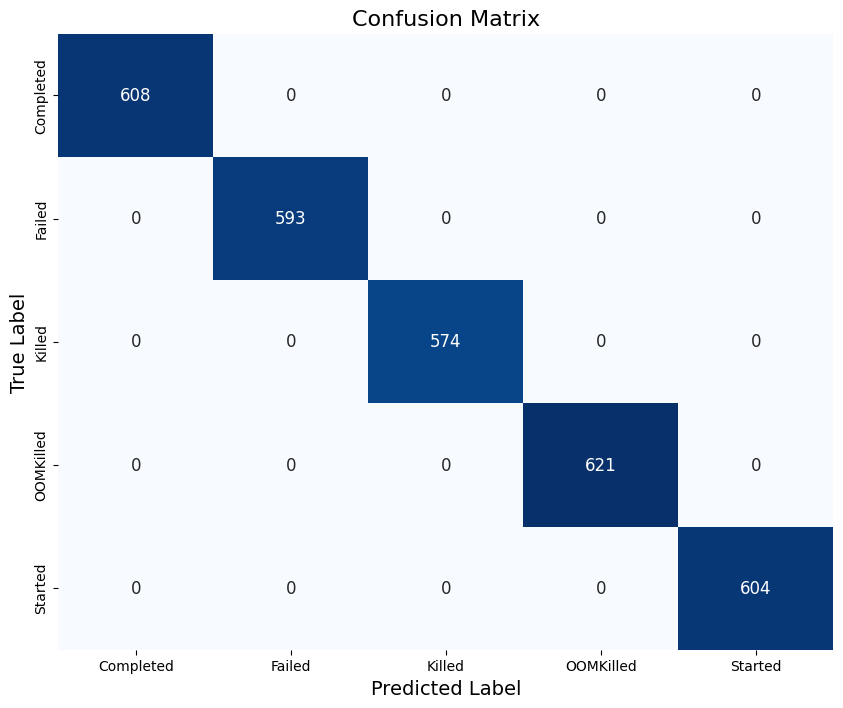

In [60]:
import seaborn as sns

# Replace 'label_encoder.classes_' with your class names if you have them as a list
class_names = label_encoder.classes_  # Real class labels from the LabelEncoder

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Plot the confusion matrix with real labels
plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False,
    xticklabels=class_names,  # Add class names as x-axis labels
    yticklabels=class_names,  # Add class names as y-axis labels
    annot_kws={"size": 12},  # Adjust annotation size
)

# Add labels and title
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()

## 6. Conclusion

In this notebook, we explored how to use **BERT**, a state-of-the-art transformer model, to classify Kubernetes events based on operational metrics and event logs. By leveraging BERT’s ability to understand contextual relationships in text, we demonstrated how transformer models can enhance the accuracy and robustness of event classification tasks in Kubernetes operations.

### Key Highlights
1. **Effective Use of Transformers**:
   - BERT’s self-attention mechanism allows it to capture complex dependencies in event messages, enabling more accurate predictions compared to traditional ML models.
2. **Comprehensive Model Evaluation**:
   - We evaluated the fine-tuned BERT model using **classification reports** and **confusion matrices**, revealing both strengths and areas for improvement in classification accuracy.
3. **Operational Insights**:
   - The fine-tuned model provided actionable insights by accurately classifying Kubernetes events like `Warning` and `Error`, which are critical for maintaining cluster health and uptime.

### What's Next?
In the next notebook, we will:
1. **Explore Advanced Transformers**:
   - Investigate newer architectures like **RoBERTa** and **GPT** to push the boundaries of classification accuracy.
2. **Implement Custom Architectures**:
   - Experiment with hybrid models that combine transformer capabilities with domain-specific feature engineering.
3. **Focus on Real-World Integration**:
   - Develop practical workflows to integrate transformer models with Kubernetes monitoring and alerting systems for automated decision-making.
